<a href="https://www.kaggle.com/erfansobhaei/persainpoemclassifier?scriptVersionId=86069627" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In this notebook, various model of transformers family will be used for classifying Persain poems specifically Rumi and Saadi poets.
We have two datasets, one small version of them containing 1000 hemistiches, and one original version containing all of their poets.

# Installing and Importing

In [1]:
#Libraries for manipulating data
import numpy as np
import pandas as pd

#Libraries for visualizaiton
import seaborn as sns
import matplotlib.pyplot as plt
import wandb

#Libraries and tools for deep learning 
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers import TrainingArguments, Trainer

In [2]:
#Download datasets
!pip install -q gdown
!gdown --id --folder 1cmrCgvpowRN4ySol4J8ZT0oVh_0v75Q_

Retrieving folder list
Retrieving folder 1BofFHgAzps0hcdbKnR6vNmj7_hlw0cKU org
Processing file 1XmfqB3ZPw8W6jicmHVtkPRekf9ze2snR poetry_rumi.txt
Processing file 11mlHdcZZJTjGcPvB7hio91D_OjB0MQRc poetry_saadi.txt
Retrieving folder 1dOatmQ0CrMEN4lmWl9Pt7v7Ts0dm7W6p small
Processing file 1nXY_40w8GHVx3ujfjBPNYFChww7Jhcvm poetry_rumi.txt
Processing file 1K-IzTHCR5u_EUm_ZXSrdR6a02qLLD-hg poetry_saadi.txt
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1XmfqB3ZPw8W6jicmHVtkPRekf9ze2snR
To: /kaggle/working/dataset/org/poetry_rumi.txt
100%|████████████████████████████████████████| 194k/194k [00:00<00:00, 76.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=11mlHdcZZJTjGcPvB7hio91D_OjB0MQRc
To: /kaggle/working/dataset/org/poetry_saadi.txt
100%|████████████████████████████████████████| 110k/110k [00:00<00:00, 71.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nXY_40w8GHVx

# Small Dataset Classification
There are two files `/dataset/small/poetry_rumi.txt` and `/dataset/small/poetry_saadi.txt`. Each of them has 1000 lines of text that we want to feed to our models as training and validation data.

## Understanding Dataset 
Let us load the data and get a gist of it!

In [3]:
#Read file and seperate each line and convert it to a DataFrame
def read_file(path, label):
    df = pd.read_csv(path, delimiter = "\n", names=["text", 'label'])
    df['label'] = label
    return df

In [4]:
#Read data from files
df_rumi_small = read_file('./dataset/small/poetry_rumi.txt', 'Rumi')
df_saadi_small = read_file('./dataset/small/poetry_saadi.txt', 'Saadi')

#Shuffle poets into one DataFrame
df_small = pd.concat([df_rumi_small, df_saadi_small], ignore_index=True)
df = df_small.sample(frac=1).reset_index(drop=True)
df.head()

,text,label
0,تا نبیند فراق دیدارت,Saadi
1,زهر از کف دست نازنینان,Saadi
2,گرت معاونتی دست می‌دهد دریاب,Saadi
3,نظر به روی تو کوری چشم اعدا را,Saadi
4,که علاج اهل هر شهری جداست,Rumi


Next let us see each poet has what fraction of data:

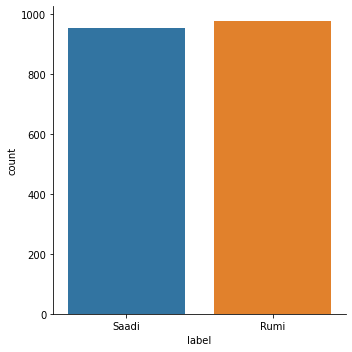

In [5]:
sns.catplot(data=df, x='label', kind='count')
plt.show()

How about each hemistich? What is the distribution of their number of words?

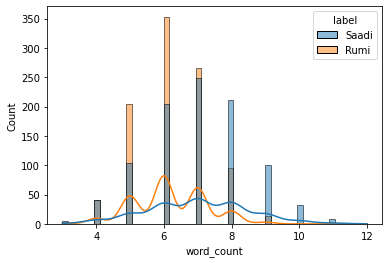

In [6]:
#Count spaces plus one for number of words
df['word_count'] = df['text'].str.count(' ') + 1

sns.histplot(data=df, x='word_count', hue='label', kde=True)
plt.show()

In the rest of this notebook, [HuggingFace](https://huggingface.co/)'s Models will help us to classify our poem! First model is:
## BERT
Bidirectional Encoder Representations from Transformers (BERT for short) was introduced in [this paper](https://arxiv.org/abs/1810.04805) and we will use [this model](https://huggingface.co/bert-base-multilingual-uncased) for our purpose.

### Loading Pretrained Model

First, we need to load pretrained model from `transformers` library

In [7]:
from transformers import BertForSequenceClassification, BertTokenizer

#Load the model
model_name = "bert-base-multilingual-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/641M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

### Preprocess Data

The data set need just a little bit of preprocssing, encoding the poet names, spliting for validation, and tokenizing each poem into its word. Next code cell will do them for us.

In [8]:
#Encode the label
df['label'] = pd.factorize(df['label'])[0]

#Split dataset
X = list(df['text'])
y = list(df['label'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

#Tokenize dataset
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

In `PyTorch` there is need to define our own dataset class, next few lines do it for us:

In [9]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, label=None):
        self.encodings = encodings
        self.label = label

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.label:
            item["label"] = torch.tensor(self.label[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

### Train Model

Now the pretrain model is loaded and ready for learning Persian literature!
Before train it on dataset, we will write a function for compute evaluation metrics.

In [10]:
def compute_metrics(p):
    preds, labels = p
    preds = np.argmax(preds, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=preds)
    f1 = f1_score(y_true=labels, y_pred=preds)

    return {"accuracy":accuracy, "f1": f1}

OK, almost done! Next code cell will define arguments for learning such as number of epochs and batch size, etc. then we will watch the model learning!

In [11]:
args = TrainingArguments(
    output_dir="output/bert",
    run_name="BERT Model",
    evaluation_strategy="epoch",
    per_device_train_batch_size=100,
    per_device_eval_batch_size=100,
    num_train_epochs=5,
    logging_steps = 10,
    seed=0,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
wandb.finish()

***** Running training *****
  Num examples = 1544
  Num Epochs = 5
  Instantaneous batch size per device = 100
  Total train batch size (w. parallel, distributed & accumulation) = 100
  Gradient Accumulation steps = 1
  Total optimization steps = 80
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.648600,0.468719,0.800518,0.784314
2,0.409500,0.448349,0.821244,0.778135
3,0.289700,0.363766,0.852332,0.830861
4,0.147800,0.397724,0.852332,0.848806
5,0.103200,0.395330,0.865285,0.855556


***** Running Evaluation *****
  Num examples = 386
  Batch size = 100
***** Running Evaluation *****
  Num examples = 386
  Batch size = 100
***** Running Evaluation *****
  Num examples = 386
  Batch size = 100
***** Running Evaluation *****
  Num examples = 386
  Batch size = 100
***** Running Evaluation *****
  Num examples = 386
  Batch size = 100


Training completed. Do not forget to share your model on huggingface.co/models =)




eval/accuracy,▁▃▇▇█
eval/f1,▂▁▆▇█
eval/loss,█▇▁▃▃
eval/runtime,█▁▁▄▄
eval/samples_per_second,▁█▇▅▅
eval/steps_per_second,▁█▇▅▅
train/epoch,▁▂▂▃▃▄▅▅▆▆▇███
train/global_step,▁▂▂▃▃▄▅▅▆▆▇███
train/learning_rate,█▇▆▅▄▃▂▁
train/loss,█▆▅▃▃▂▁▁
train/total_flos,▁


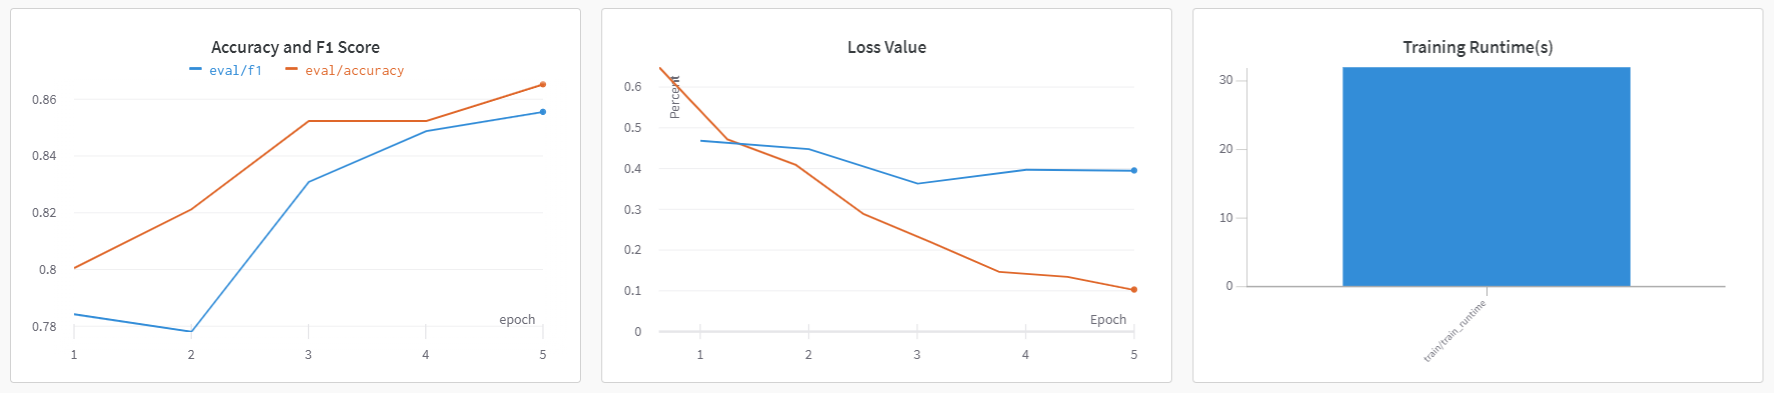

BERT did a real good job! The accuracy and F1 socre reached 0.86 so the model has low bias. Difference between validation loss and training loss is a little bit large which suggests that the model is prone to overfit and need more data. Average runtime for each epoch was about 30 seconds.
Let us see the next model and compare it with BERT!

## XLMRoBERTa

Second model is XLMRoBERTa which is multilingual version of RoBERTa. This model was introduced in [this](https://arxiv.org/abs/1911.02116) and the correspondent model is [this model](https://huggingface.co/xlm-roberta-base). This model is very heavier than BERT, it will take more time but is expected to return better results. 

### Loading Pretrained Model

In [12]:
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizer

#Load the model
model_name = "xlm-roberta-base"
tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)
model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)

https://huggingface.co/xlm-roberta-base/resolve/main/sentencepiece.bpe.model not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpxyau4jbg


Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

storing https://huggingface.co/xlm-roberta-base/resolve/main/sentencepiece.bpe.model in cache at /root/.cache/huggingface/transformers/9df9ae4442348b73950203b63d1b8ed2d18eba68921872aee0c3a9d05b9673c6.00628a9eeb8baf4080d44a0abe9fe8057893de20c7cb6e6423cddbf452f7d4d8
creating metadata file for /root/.cache/huggingface/transformers/9df9ae4442348b73950203b63d1b8ed2d18eba68921872aee0c3a9d05b9673c6.00628a9eeb8baf4080d44a0abe9fe8057893de20c7cb6e6423cddbf452f7d4d8
https://huggingface.co/xlm-roberta-base/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp0nwb0kaz


Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

storing https://huggingface.co/xlm-roberta-base/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/daeda8d936162ca65fe6dd158ecce1d8cb56c17d89b78ab86be1558eaef1d76a.a984cf52fc87644bd4a2165f1e07e0ac880272c1e82d648b4674907056912bd7
creating metadata file for /root/.cache/huggingface/transformers/daeda8d936162ca65fe6dd158ecce1d8cb56c17d89b78ab86be1558eaef1d76a.a984cf52fc87644bd4a2165f1e07e0ac880272c1e82d648b4674907056912bd7
loading file https://huggingface.co/xlm-roberta-base/resolve/main/sentencepiece.bpe.model from cache at /root/.cache/huggingface/transformers/9df9ae4442348b73950203b63d1b8ed2d18eba68921872aee0c3a9d05b9673c6.00628a9eeb8baf4080d44a0abe9fe8057893de20c7cb6e6423cddbf452f7d4d8
loading file https://huggingface.co/xlm-roberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/xlm-roberta-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/xlm-roberta-base/resolve/main

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

storing https://huggingface.co/xlm-roberta-base/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/87683eb92ea383b0475fecf99970e950a03c9ff5e51648d6eee56fb754612465.ab95cf27f9419a99cce4f19d09e655aba382a2bafe2fe26d0cc24c18cf1a1af6
creating metadata file for /root/.cache/huggingface/transformers/87683eb92ea383b0475fecf99970e950a03c9ff5e51648d6eee56fb754612465.ab95cf27f9419a99cce4f19d09e655aba382a2bafe2fe26d0cc24c18cf1a1af6
loading configuration file https://huggingface.co/xlm-roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/87683eb92ea383b0475fecf99970e950a03c9ff5e51648d6eee56fb754612465.ab95cf27f9419a99cce4f19d09e655aba382a2bafe2fe26d0cc24c18cf1a1af6
Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "in

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

storing https://huggingface.co/xlm-roberta-base/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/97d0ea09f8074264957d062ec20ccb79af7b917d091add8261b26874daf51b5d.f42212747c1c27fcebaa0a89e2a83c38c6d3d4340f21922f892b88d882146ac2
creating metadata file for /root/.cache/huggingface/transformers/97d0ea09f8074264957d062ec20ccb79af7b917d091add8261b26874daf51b5d.f42212747c1c27fcebaa0a89e2a83c38c6d3d4340f21922f892b88d882146ac2
loading weights file https://huggingface.co/xlm-roberta-base/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/97d0ea09f8074264957d062ec20ccb79af7b917d091add8261b26874daf51b5d.f42212747c1c27fcebaa0a89e2a83c38c6d3d4340f21922f892b88d882146ac2
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm

### Preprocess Data

In [13]:
X = list(df['text'])
y = list(df['label'])

#Split and tokenize dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=128)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=128)

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [14]:
args = TrainingArguments(
    output_dir="output/xlmroberta",
    run_name="XLMRoBERTa Model",
    evaluation_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    logging_steps =10,
    seed=0,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
wandb.finish()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 1544
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 245
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: erfansobhaei (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.696100,0.697551,0.489637,0.657391
2,0.690400,0.631400,0.696891,0.603390
3,0.533200,0.539193,0.782383,0.771739
4,0.470600,0.514413,0.743523,0.687697
5,0.368600,0.411951,0.834197,0.840000


***** Running Evaluation *****
  Num examples = 386
  Batch size = 32
***** Running Evaluation *****
  Num examples = 386
  Batch size = 32
***** Running Evaluation *****
  Num examples = 386
  Batch size = 32
***** Running Evaluation *****
  Num examples = 386
  Batch size = 32
***** Running Evaluation *****
  Num examples = 386
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




eval/accuracy,▁▅▇▆█
eval/f1,▃▁▆▃█
eval/loss,█▆▄▄▁
eval/runtime,▃▁▄█▄
eval/samples_per_second,▆█▅▁▅
eval/steps_per_second,▆█▅▁▅
train/epoch,▁▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇████
train/global_step,▁▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇████
train/learning_rate,██▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▁▁
train/loss,█████████▇▆▆▆▄▄▄▂▂▃▂▁▁▂▁
train/total_flos,▁


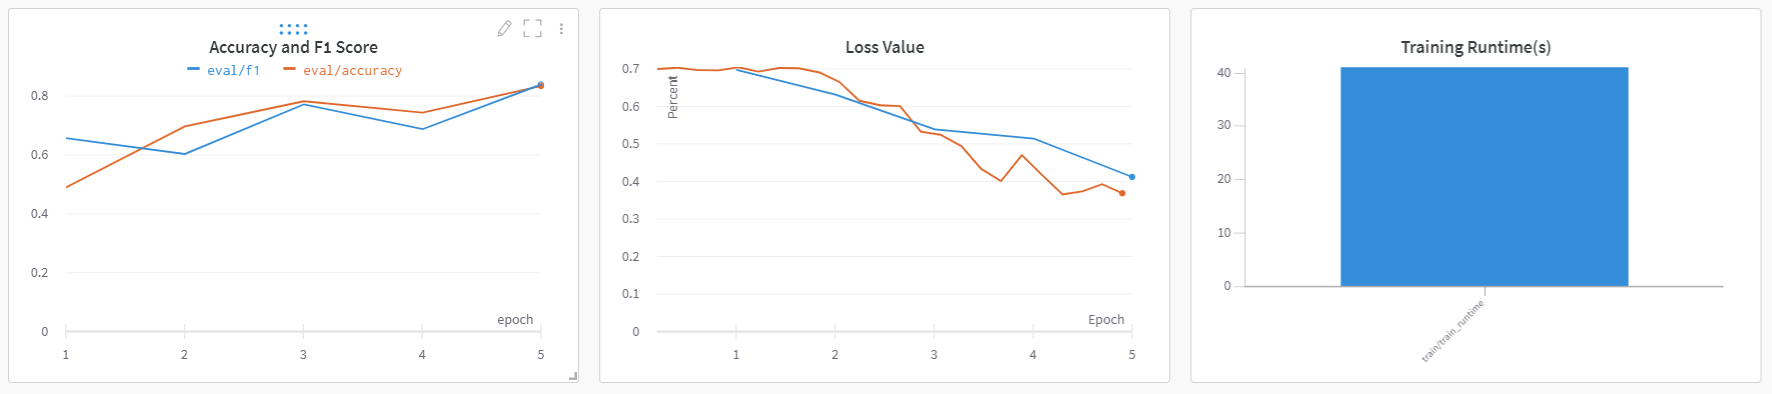

Despite the expectations, the accuracy was lower than BERT it may be beacause of small dataset and in the original dataset it probably does better than 0.8. Two loss values are very near each other and this is a sign of proper abbility for generalization of this model, and as we expect this model consume 40 seconds on average for each epoch.

There is also a third model so let's meet DistrilBERT.

## DistrilBERT
Third model is DistrilBERT. Main purpose of this model was reduce required resources rather than better performance. The can be found in [this link](https://huggingface.co/distilbert-base-multilingual-cased). We assume that this model will be faster to train but has lower accuracy. Let's see the results!

### Loading Pretrained Model

In [15]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer 

#Load the model
model_name = "distilbert-base-multilingual-cased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmprzucz8dr


Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/28e5b750bf4f39cc620367720e105de1501cf36ec4ca7029eba82c1d2cc47caf.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29
creating metadata file for /root/.cache/huggingface/transformers/28e5b750bf4f39cc620367720e105de1501cf36ec4ca7029eba82c1d2cc47caf.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29
https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpy9ognvvt


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/47087d99feeb3bc6184d7576ff089c52f7fbe3219fe48c6c4fa681e617753256.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
creating metadata file for /root/.cache/huggingface/transformers/47087d99feeb3bc6184d7576ff089c52f7fbe3219fe48c6c4fa681e617753256.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp9lfbtny3


Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/5cbdf121f196be5f1016cb102b197b0c34009e1e658f513515f2eebef9f38093.b33e51591f94f17c238ee9b1fac75b96ff2678cbaed6e108feadb3449d18dc24
creating metadata file for /root/.cache/huggingface/transformers/5cbdf121f196be5f1016cb102b197b0c34009e1e658f513515f2eebef9f38093.b33e51591f94f17c238ee9b1fac75b96ff2678cbaed6e108feadb3449d18dc24
loading file https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/28e5b750bf4f39cc620367720e105de1501cf36ec4ca7029eba82c1d2cc47caf.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29
loading file https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/special_tokens_map.json from cache at None
loading

Downloading:   0%|          | 0.00/466 [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/cf37a9dc282a679f121734d06f003625d14cfdaf55c14358c4c0b8e7e2b89ac9.7a727bd85e40715bec919a39cdd6f0aba27a8cd488f2d4e0f512448dcd02bf0f
creating metadata file for /root/.cache/huggingface/transformers/cf37a9dc282a679f121734d06f003625d14cfdaf55c14358c4c0b8e7e2b89ac9.7a727bd85e40715bec919a39cdd6f0aba27a8cd488f2d4e0f512448dcd02bf0f
loading configuration file https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/cf37a9dc282a679f121734d06f003625d14cfdaf55c14358c4c0b8e7e2b89ac9.7a727bd85e40715bec919a39cdd6f0aba27a8cd488f2d4e0f512448dcd02bf0f
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embed

Downloading:   0%|          | 0.00/517M [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/7b48683e2e7ba71cd1d7d6551ac325eceee01db5c2f3e81cfbfd1ee7bb7877f2.c24097b0cf91dbc66977325325fd03112f0f13d0e3579abbffc8d1e45f8d0619
creating metadata file for /root/.cache/huggingface/transformers/7b48683e2e7ba71cd1d7d6551ac325eceee01db5c2f3e81cfbfd1ee7bb7877f2.c24097b0cf91dbc66977325325fd03112f0f13d0e3579abbffc8d1e45f8d0619
loading weights file https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/7b48683e2e7ba71cd1d7d6551ac325eceee01db5c2f3e81cfbfd1ee7bb7877f2.c24097b0cf91dbc66977325325fd03112f0f13d0e3579abbffc8d1e45f8d0619
Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transf

In [16]:
X = list(df['text'])
y = list(df['label'])

#Split and tokenize dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [17]:
args = TrainingArguments(
    output_dir="output/distilbert",
    run_name="DistilBERT Model",
    evaluation_strategy="epoch",
    per_device_train_batch_size=100,
    per_device_eval_batch_size=100,
    num_train_epochs=5,
    logging_steps =10,
    seed=0,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
wandb.finish()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 1544
  Num Epochs = 5
  Instantaneous batch size per device = 100
  Total train batch size (w. parallel, distributed & accumulation) = 100
  Gradient Accumulation steps = 1
  Total optimization steps = 80
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.667800,0.490779,0.759067,0.740947
2,0.339600,0.375789,0.841969,0.839050
3,0.232400,0.390913,0.849741,0.856436
4,0.123100,0.401944,0.865285,0.862434
5,0.111900,0.382481,0.867876,0.872818


***** Running Evaluation *****
  Num examples = 386
  Batch size = 100
***** Running Evaluation *****
  Num examples = 386
  Batch size = 100
***** Running Evaluation *****
  Num examples = 386
  Batch size = 100
***** Running Evaluation *****
  Num examples = 386
  Batch size = 100
***** Running Evaluation *****
  Num examples = 386
  Batch size = 100


Training completed. Do not forget to share your model on huggingface.co/models =)




eval/accuracy,▁▆▇██
eval/f1,▁▆▇▇█
eval/loss,█▁▂▃▁
eval/runtime,▁▁▁▂█
eval/samples_per_second,███▇▁
eval/steps_per_second,███▇▁
train/epoch,▁▂▂▃▃▄▅▅▆▆▇███
train/global_step,▁▂▂▃▃▄▅▅▆▆▇███
train/learning_rate,█▇▆▅▄▃▂▁
train/loss,█▆▄▃▂▁▁▁
train/total_flos,▁


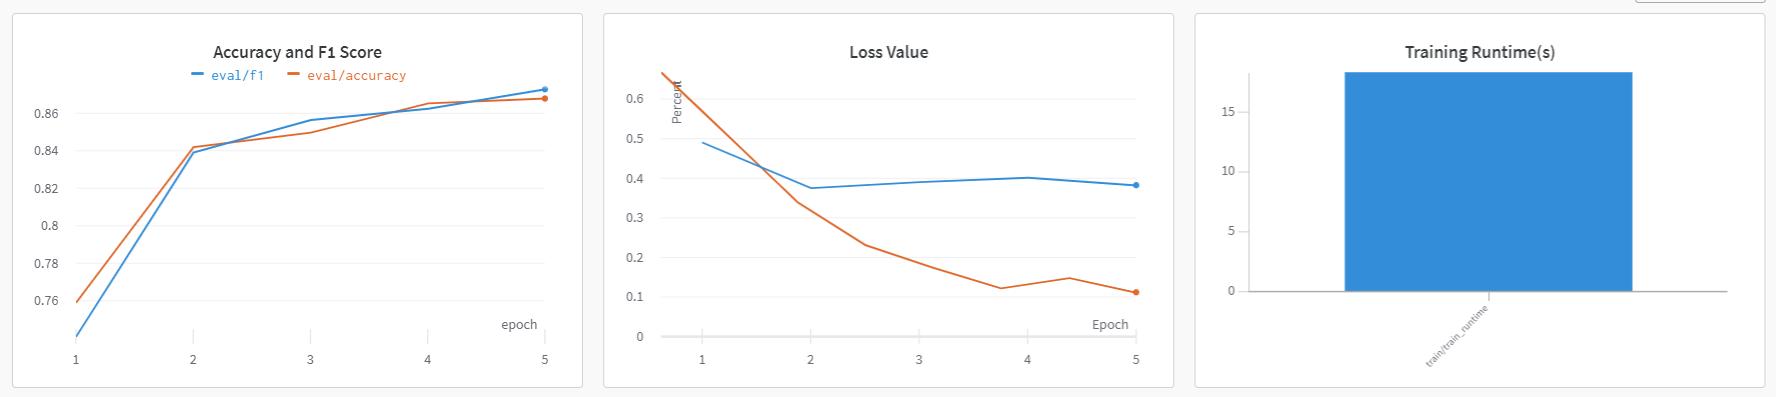

DistrilBERT had a great performance! It reached about 0.86 accuracy and F1 Score which is higher than RoBERTa but lower than BERT. Also its losses does not show any noticable sign of overfitting. On the other hand, DistrilBERT was a appreicable advantage! Average runtime for each epoch is about 15 seconds which is way lower than two other models.

## Conclusion
From the above results we can conclude three main points:
1. For limited resource, DistrilBERT is best. It will consume low amount of time and has nice performance.
2. For small dataset, RoBERTa is not a good choice at all! It consume a lot of time and also it cannot reduce loss values.
3. For high accuracy on small dataset, BERT is great. It will reach about 0.9 accuracy and of course it can go higher with better hyperparameters. 

# Original Dataset Classification
We saw result of three models on small dataset, so it this section we tend to test them for the original dataset.

## Understanding Dataset 

In [18]:
df_rumi_org = read_file('./dataset/org/poetry_rumi.txt', 'Rumi')
df_saadi_org = read_file('./dataset/org/poetry_saadi.txt', 'Saadi')

df_org = pd.concat([df_rumi_org, df_saadi_org], ignore_index=True)
df = df_org.sample(frac=1).reset_index(drop=True)
df.head()

,text,label
0,سوی شهر خویش آرد بهرها,Rumi
1,می‌کشم نفس و می‌کشم بارت,Saadi
2,بر جور و بی مرادی و درویشی و هلاک,Saadi
3,بعد از آنش از قفس بیرون فکند,Rumi
4,دوش در خوابم در آغوش آمدی,Saadi


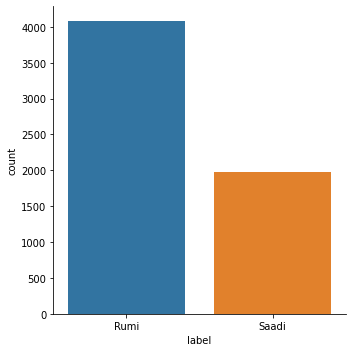

In [19]:
sns.catplot(data=df, x='label', kind='count')
plt.show()

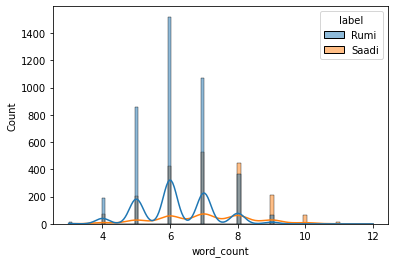

In [20]:
df['word_count'] = df['text'].str.count(' ') + 1

sns.histplot(data=df, x='word_count', hue='label', kde=True)
plt.show()

# BERT

In [21]:
model_name = "bert-base-multilingual-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

df['label'] = pd.factorize(df['label'])[0]
X = list(df['text'])
y = list(df['label'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

args = TrainingArguments(
    output_dir="output_org/bert",
    run_name="BERT Model",
    evaluation_strategy="epoch",
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    num_train_epochs=5,
    logging_steps = 10,
    seed=0,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
wandb.finish()

loading file https://huggingface.co/bert-base-multilingual-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/269f2943d168a4cd2ddf3864cee89d7f7d78873b3d14a1229174d37212981a38.92022aa29ab6663b0b4254744f28ab43e6adf4deebe0f26651e6c61f28f69d8b
loading file https://huggingface.co/bert-base-multilingual-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-multilingual-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-multilingual-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/1b935b135ddb021a7d836c00f5702b80d11d348fd5c5a42cbd933d8ed1f55be9.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading file https://huggingface.co/bert-base-multilingual-uncased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/857db185d48b92f3e6141ef5092d8d5dbebab7eef1bacc6c9eaf85cf2

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.627600,0.390456,0.860561,0.768176
2,0.323600,0.267530,0.895215,0.823856
3,0.217300,0.376321,0.876238,0.762658
4,0.164900,0.235341,0.911716,0.853224
5,0.145700,0.242436,0.911716,0.856376


***** Running Evaluation *****
  Num examples = 1212
  Batch size = 256
***** Running Evaluation *****
  Num examples = 1212
  Batch size = 256
***** Running Evaluation *****
  Num examples = 1212
  Batch size = 256
***** Running Evaluation *****
  Num examples = 1212
  Batch size = 256
***** Running Evaluation *****
  Num examples = 1212
  Batch size = 256


Training completed. Do not forget to share your model on huggingface.co/models =)




eval/accuracy,▁▆▃██
eval/f1,▁▆▁██
eval/loss,█▂▇▁▁
eval/runtime,▁▃▃▄█
eval/samples_per_second,█▆▆▅▁
eval/steps_per_second,█▆▆▅▁
train/epoch,▁▂▂▃▃▃▄▅▅▆▆▇███
train/global_step,▁▂▂▃▃▃▄▅▅▆▆▇███
train/learning_rate,█▇▆▅▄▄▃▂▁
train/loss,█▅▄▃▂▂▁▁▁
train/total_flos,▁


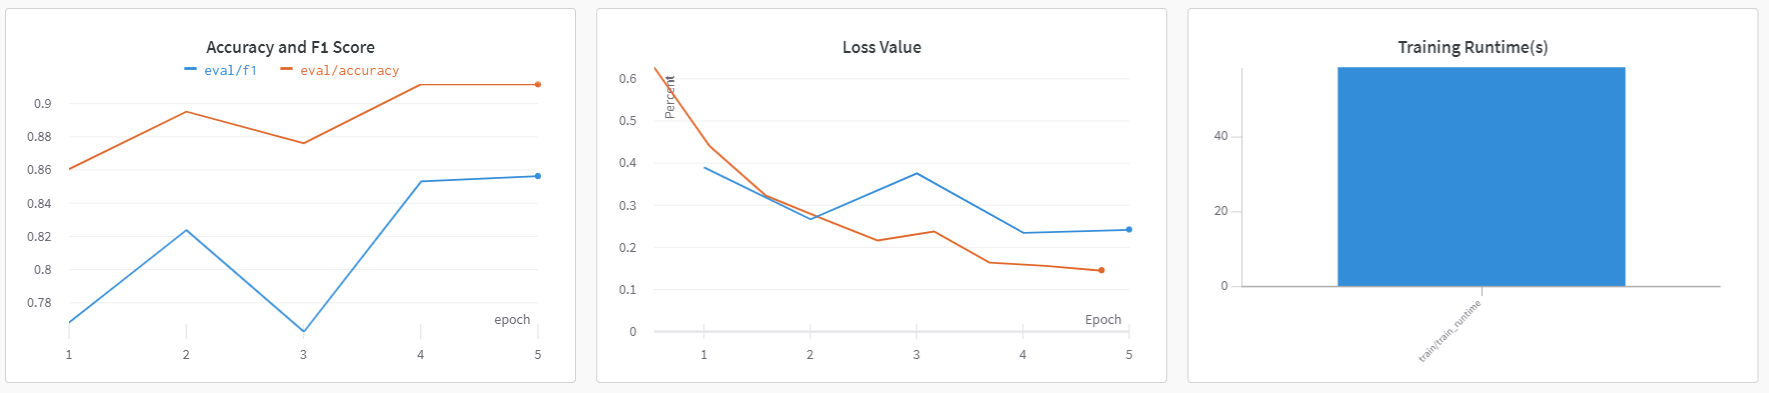

As we expect, the accuracy and F1 socre got better due to larger dataset. Loss values are near each other and it suggest not high varicane and good generaliziation of model. Average time for each epoch was about 60 seconds. Let's see two other models.

## XLMRoBERTa

In [23]:
#Load the model
model_name = "xlm-roberta-base"
tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)
model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)

#Tokenize data
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

args = TrainingArguments(
    output_dir="output_org/xlmroberta",
    run_name="XLMRoberta Model",
    evaluation_strategy="epoch",
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    num_train_epochs=5,
    logging_steps = 10,
    seed=0,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
wandb.finish()

loading file https://huggingface.co/xlm-roberta-base/resolve/main/sentencepiece.bpe.model from cache at /root/.cache/huggingface/transformers/9df9ae4442348b73950203b63d1b8ed2d18eba68921872aee0c3a9d05b9673c6.00628a9eeb8baf4080d44a0abe9fe8057893de20c7cb6e6423cddbf452f7d4d8
loading file https://huggingface.co/xlm-roberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/xlm-roberta-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/xlm-roberta-base/resolve/main/tokenizer_config.json from cache at None
loading file https://huggingface.co/xlm-roberta-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/daeda8d936162ca65fe6dd158ecce1d8cb56c17d89b78ab86be1558eaef1d76a.a984cf52fc87644bd4a2165f1e07e0ac880272c1e82d648b4674907056912bd7
loading configuration file https://huggingface.co/xlm-roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/87

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.662800,0.588456,0.679868,0.015228
2,0.537500,0.410162,0.813531,0.747768
3,0.389200,0.336517,0.867987,0.803922
4,0.306300,0.339094,0.877888,0.822967
5,0.295700,0.289339,0.893564,0.838548


***** Running Evaluation *****
  Num examples = 1212
  Batch size = 256
***** Running Evaluation *****
  Num examples = 1212
  Batch size = 256
***** Running Evaluation *****
  Num examples = 1212
  Batch size = 256
***** Running Evaluation *****
  Num examples = 1212
  Batch size = 256
***** Running Evaluation *****
  Num examples = 1212
  Batch size = 256


Training completed. Do not forget to share your model on huggingface.co/models =)




eval/accuracy,▁▅▇▇█
eval/f1,▁▇███
eval/loss,█▄▂▂▁
eval/runtime,▅▁█▇▁
eval/samples_per_second,▄█▁▂█
eval/steps_per_second,▄█▁▂█
train/epoch,▁▂▂▃▃▃▄▅▅▆▆▇███
train/global_step,▁▂▂▃▃▃▄▅▅▆▆▇███
train/learning_rate,█▇▆▅▄▄▃▂▁
train/loss,█▇▆▄▃▂▁▁▁
train/total_flos,▁


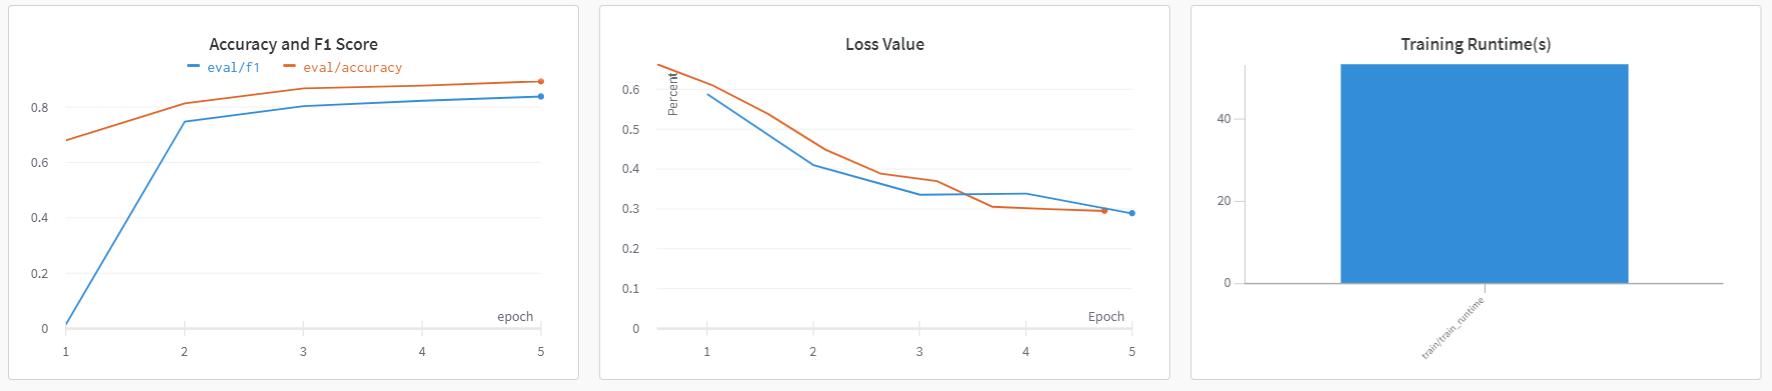

Both values of accuracy and loss are near each other so we can be sure that the model is not overfitted. The value of accuracy is about 0.8 which is, agian, lower than BERT but this time, consumed time is roughly the same. Probably this model would do better than BERT for more epoch (we can conclude that from the learning curves) but for 5 epochs its performance is not accetpable.

## DistilBERT

In [24]:
model_name = "distilbert-base-multilingual-cased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

args = TrainingArguments(
    output_dir="output_org/distilbert",
    run_name="Distil BERT Model",
    evaluation_strategy="epoch",
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    num_train_epochs=5,
    logging_steps = 10,
    seed=0,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
wandb.finish()

loading file https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/28e5b750bf4f39cc620367720e105de1501cf36ec4ca7029eba82c1d2cc47caf.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29
loading file https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/47087d99feeb3bc6184d7576ff089c52f7fbe3219fe48c6c4fa681e617753256.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
loading file https://huggingface.co/distilbert-base-multilingual-cased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/5cbdf121f196be5f1016cb102b197b0c34009

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.624900,0.405474,0.840759,0.757233
2,0.356900,0.294873,0.880363,0.785185
3,0.245600,0.294395,0.892739,0.804217
4,0.207100,0.255177,0.897690,0.847291
5,0.181400,0.225671,0.910066,0.854473


***** Running Evaluation *****
  Num examples = 1212
  Batch size = 256
***** Running Evaluation *****
  Num examples = 1212
  Batch size = 256
***** Running Evaluation *****
  Num examples = 1212
  Batch size = 256
***** Running Evaluation *****
  Num examples = 1212
  Batch size = 256
***** Running Evaluation *****
  Num examples = 1212
  Batch size = 256


Training completed. Do not forget to share your model on huggingface.co/models =)




eval/accuracy,▁▅▆▇█
eval/f1,▁▃▄▇█
eval/loss,█▄▄▂▁
eval/runtime,▄▁▅▂█
eval/samples_per_second,▅█▄▇▁
eval/steps_per_second,▅█▄▇▁
train/epoch,▁▂▂▃▃▃▄▅▅▆▆▇███
train/global_step,▁▂▂▃▃▃▄▅▅▆▆▇███
train/learning_rate,█▇▆▅▄▄▃▂▁
train/loss,█▆▄▃▂▂▁▂▁
train/total_flos,▁


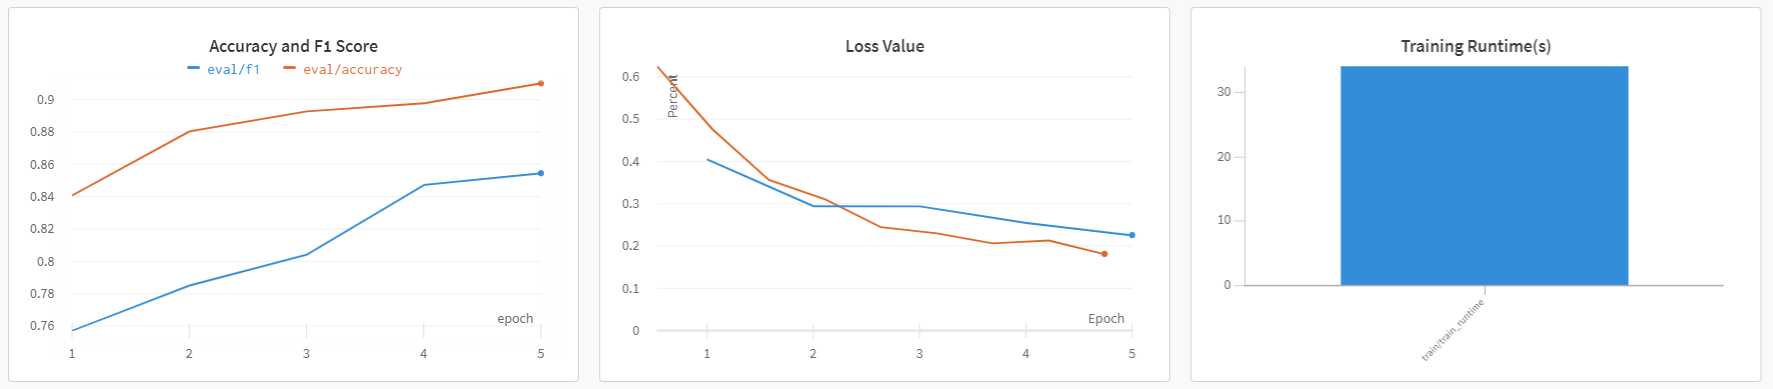

Again, best part of DistrilBERT is its time, its roughly the half of two other models! About the accuracy and F1 score is not bad and its accuracy reached 0.9, maybe with more balanced data its F1 score could reach higher. Loss values are roughly the same and it has low variance and could learn better with more epochs. 

## Conclusion
So following points can be inferred from results:
1. BERT can have acceptable results for both small and large datasets but for large datasets, it could be time consuming.
2. For using RoBERTa you need a lot of time and data, huge (not just large dataset)! In relativly small datasets it does not provide proper results. (It is possible that XLMRoBERTa does not support Persian good enough but unfortunately there is not multilingual RoBERTa model since now).
3. DistilBERT is best for limited time resource. It can reach good accuracy in a little amount of time.